In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [3]:
# === Step 1: Load Data ===
df = pd.read_csv("linear_motion_test.csv")
df['Time'] = (df['Timestamp'] - df['Timestamp'].iloc[0]) / 1000  # seconds

# === Step 2: Calibration ===
bias = np.array([0.38395, -0.1313, 0.43695])
rotation_matrix = np.array([
    [0.99895341, -0.00842065,  0.04495761],
    [0.01155954,  0.99992051, -0.00503448],
    [-0.05108319, 0.00527653,  0.99868046]
])
scale_matrix = np.array([
    [1.00173649, 0, 0],
    [0, 1.00529907, 0],
    [0, 0, 1.01810694]
])

inv_rotation = np.linalg.inv(rotation_matrix)
inv_scale = np.linalg.inv(scale_matrix)

calibrated = []
for _, row in df.iterrows():
    raw = np.array([row['aX (g)'], row['aY (g)'], row['aZ (g)']])
    corrected = raw
    calibrated.append(corrected)

calibrated = np.array(calibrated)
df['aX_cal'] = calibrated[:, 0]
df['aY_cal'] = calibrated[:, 1]
df['aZ_cal'] = calibrated[:, 2]

bias_ax = df['aX_cal'][:500].mean()
bias_ay = df['aY_cal'][:500].mean()
bias_az = df['aZ_cal'][:500].mean()

# Subtract the bias from the entire column
df['aX_cal'] = df['aX_cal'] - bias_ax
df['aY_cal'] = df['aY_cal'] - bias_ay
df['aZ_cal'] = df['aZ_cal'] - bias_az

In [4]:
from scipy.signal import butter, filtfilt

# === Step 3: Low-pass filter using Butterworth ===

def low_pass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    norm_cutoff = cutoff / nyquist
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Estimate sampling frequency from time data
dt = df['Time'].diff().mean()
fs = 1 / dt  # Hz

cutoff = 5 # Hz – adjust depending on motion speed

df['aX_raw_smooth'] = df['aX (g)']
df['aY_raw_smooth'] = df['aY (g)']
df['aZ_raw_smooth'] = df['aZ (g)']

# Apply low-pass filter to calibrated data
df['aX_cal_smooth'] = df['aX_cal']
df['aY_cal_smooth'] = df['aY_cal']
df['aZ_cal_smooth'] = df['aZ_cal']


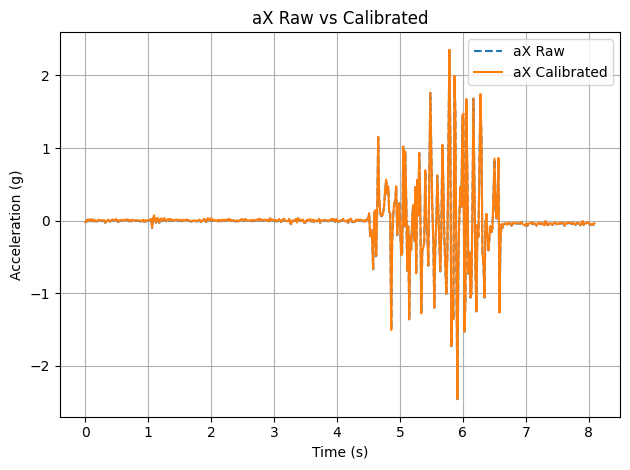

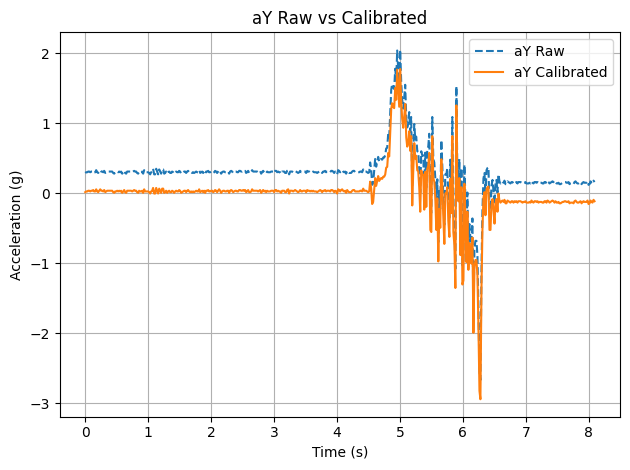

In [5]:

# === Step 4: Acceleration Plot ===
plt.figure()
plt.plot(df['Time'], df['aX_raw_smooth'], label='aX Raw', linestyle='--')
plt.plot(df['Time'], df['aX_cal_smooth'], label='aX Calibrated')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('aX Raw vs Calibrated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('aX_comparison.png')
plt.show()

plt.figure()
plt.plot(df['Time'], df['aY_raw_smooth'], label='aY Raw', linestyle='--')
plt.plot(df['Time'], df['aY_cal_smooth'], label='aY Calibrated')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('aY Raw vs Calibrated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('aY_comparison.png')
plt.show()


In [6]:

# === Step 5: Convert to m/s² ===
df['aX_raw_mps2'] = df['aX_raw_smooth'] 
df['aY_raw_mps2'] = df['aY_raw_smooth'] 
df['aX_cal_mps2'] = df['aX_cal_smooth'] 
df['aY_cal_mps2'] = df['aY_cal_smooth'] 

# === Step 6: Velocity Integration ===
vx_raw = [0]
vy_raw = [0]
vx_cal = [0]
vy_cal = [0]

for i in range(1, len(df)):
    dt = df['Time'].iloc[i] - df['Time'].iloc[i - 1]
    # Raw
    ax_avg_raw = 0.5 * (df['aX_raw_mps2'].iloc[i] + df['aX_raw_mps2'].iloc[i - 1])
    ay_avg_raw = 0.5 * (df['aY_raw_mps2'].iloc[i] + df['aY_raw_mps2'].iloc[i - 1])
    vx_raw.append(vx_raw[-1] + ax_avg_raw * dt)
    vy_raw.append(vy_raw[-1] + ay_avg_raw * dt)
    # Calibrated
    ax_avg_cal = 0.5 * (df['aX_cal_mps2'].iloc[i] + df['aX_cal_mps2'].iloc[i - 1])
    ay_avg_cal = 0.5 * (df['aY_cal_mps2'].iloc[i] + df['aY_cal_mps2'].iloc[i - 1])
    vx_cal.append(vx_cal[-1] + ax_avg_cal * dt)
    vy_cal.append(vy_cal[-1] + ay_avg_cal * dt)

df['vX_raw'] = vx_raw
df['vY_raw'] = vy_raw
df['vX_cal'] = vx_cal
df['vY_cal'] = vy_cal

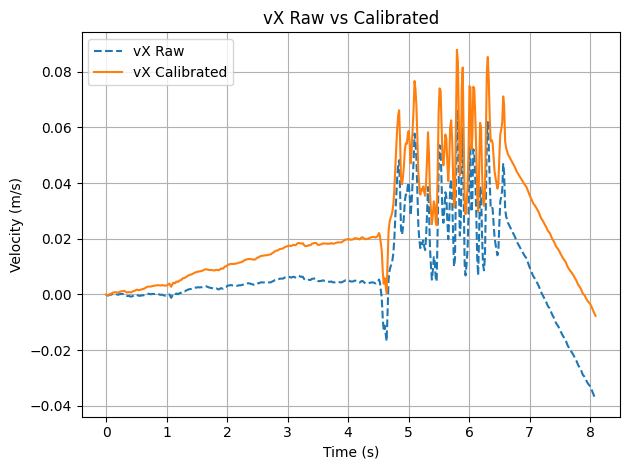

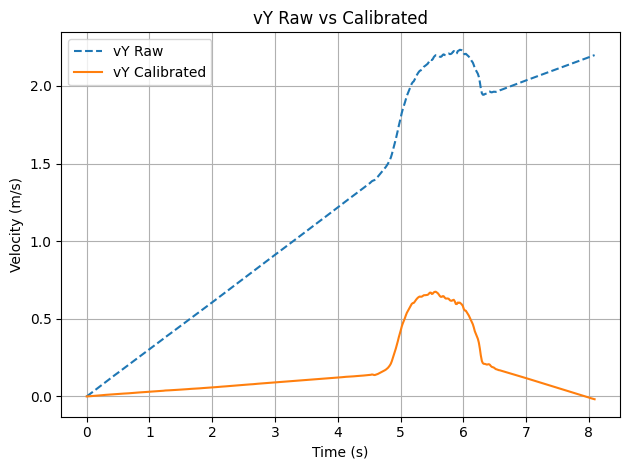

In [7]:

# === Step 7: Velocity Plot ===
plt.figure()
plt.plot(df['Time'], df['vX_raw'], label='vX Raw', linestyle='--')
plt.plot(df['Time'], df['vX_cal'], label='vX Calibrated')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('vX Raw vs Calibrated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('velocity_x_comparison.png')
plt.show()

plt.figure()
plt.plot(df['Time'], df['vY_raw'], label='vY Raw', linestyle='--')
plt.plot(df['Time'], df['vY_cal'], label='vY Calibrated')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('vY Raw vs Calibrated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('velocity_y_comparison.png')
plt.show()

In [8]:
# === Step 8: Position Integration ===
px_raw = [0]
py_raw = [0]
px_cal = [0]
py_cal = [0]

for i in range(1, len(df)):
    dt = df['Time'].iloc[i] - df['Time'].iloc[i - 1]
    # Raw
    vx_avg_raw = 0.5 * (df['vX_raw'].iloc[i] + df['vX_raw'].iloc[i - 1])
    vy_avg_raw = 0.5 * (df['vY_raw'].iloc[i] + df['vY_raw'].iloc[i - 1])
    px_raw.append(px_raw[-1] + vx_avg_raw * dt)
    py_raw.append(py_raw[-1] + vy_avg_raw * dt)
    # Calibrated
    vx_avg_cal = 0.5 * (df['vX_cal'].iloc[i] + df['vX_cal'].iloc[i - 1])
    vy_avg_cal = 0.5 * (df['vY_cal'].iloc[i] + df['vY_cal'].iloc[i - 1])
    px_cal.append(px_cal[-1] + vx_avg_cal * dt)
    py_cal.append(py_cal[-1] + vy_avg_cal * dt)

df['posX_raw'] = px_raw
df['posY_raw'] = py_raw
df['posX_cal'] = px_cal
df['posY_cal'] = py_cal

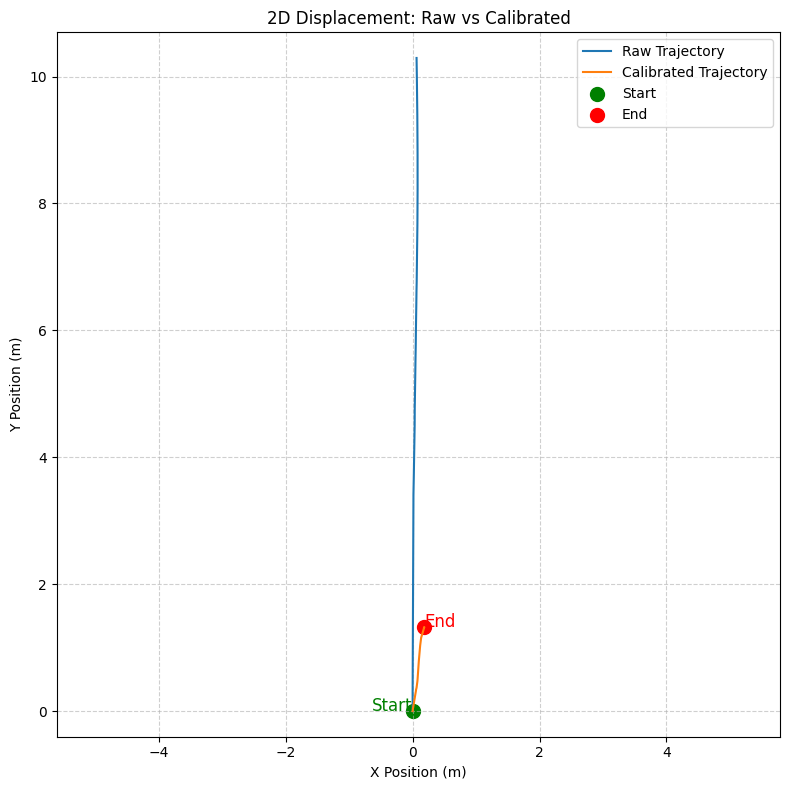

In [9]:
# === Step 9: Position Plot ===
plt.figure(figsize=(8, 8))

plt.plot(df['posX_raw'], df['posY_raw'], label='Raw Trajectory')
plt.plot(df['posX_cal'], df['posY_cal'], label='Calibrated Trajectory')

plt.scatter(df['posX_cal'].iloc[0], df['posY_cal'].iloc[0], color='green', s=100, label='Start')
plt.text(df['posX_cal'].iloc[0], df['posY_cal'].iloc[0], 'Start', fontsize=12, color='green', ha='right')

plt.scatter(df['posX_cal'].iloc[-1], df['posY_cal'].iloc[-1], color='red', s=100, label='End')
plt.text(df['posX_cal'].iloc[-1], df['posY_cal'].iloc[-1], 'End', fontsize=12, color='red', ha='left')


plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('2D Displacement: Raw vs Calibrated')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.savefig("trajectory_comparison.png", dpi=300)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Ensure Z position exists — default to zero if not integrated
df['posZ_raw'] = 0
df['posZ_cal'] = 0

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot RAW position vs time
ax.plot(df['Time'], df['posX_raw'], df['posY_raw'], label='Raw Position', linestyle='--', color='gray')

# Plot CALIBRATED position vs time
ax.plot(df['Time'], df['posX_cal'], df['posY_cal'], label='Calibrated Position', color='blue')

# Labels and formatting
ax.set_xlabel('Time (s)')
ax.set_ylabel('X Position (m)')
ax.set_zlabel('Y Position (m)')
ax.set_title('3D Position over Time (Raw vs Calibrated)')
ax.legend()
plt.tight_layout()
plt.savefig("3d_position_vs_time_comparison.png", dpi=300)
plt.show()
